In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import shap
import seaborn as sns
from scipy.stats import norm
import tensorflow as tf
import polars as pl
from sklearn.tree import plot_tree
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression


In [2]:
weatherdata = pd.read_csv('data\weatheranddeliquency_data.csv')


# remove last 2 columns
weatherdata = weatherdata.iloc[:, :-2]

# save the data to a new csv file
weatherdata.to_csv('data\weather_data.csv', index=False)

In [3]:
# read csv file by polars

# Load data with specific columns to reduce memory usage
df = pd.read_csv('data/FL.csv', usecols=['FIRST PAYMENT DATE', 'CREDIT SCORE', 'ORIGINAL LOAN AMOUNT', 'AMORTIZATION TYPE', 'PROPERTY TYPE'])

# Convert 'FIRST PAYMENT DATE' to datetime format
df['FIRST PAYMENT DATE'] = pd.to_datetime(df['FIRST PAYMENT DATE'], format='%Y%m')

# get the bank close data by reduce one month from the 'FIRST PAYMENT DATE'
df['ESTIMATE BANK CLOSE DATE'] = df['FIRST PAYMENT DATE'] - pd.DateOffset(months=1)

# resort the columns
df = df[['FIRST PAYMENT DATE', 'ESTIMATE BANK CLOSE DATE', 'CREDIT SCORE', 'ORIGINAL LOAN AMOUNT', 'AMORTIZATION TYPE', 'PROPERTY TYPE']]

In [4]:
df['ESTIMATE BANK CLOSE DATE'] = pd.to_datetime(df['ESTIMATE BANK CLOSE DATE']).dt.to_period('M')
df['FIRST PAYMENT DATE'] = pd.to_datetime(df['FIRST PAYMENT DATE']).dt.to_period('M')
df.head()


,FIRST PAYMENT DATE,ESTIMATE BANK CLOSE DATE,CREDIT SCORE,ORIGINAL LOAN AMOUNT,AMORTIZATION TYPE,PROPERTY TYPE
0,1999-03,1999-02,739,39000,FRM,SF
1,1999-05,1999-04,706,123000,FRM,PU
2,1999-05,1999-04,546,94000,FRM,SF
3,1999-03,1999-02,642,38000,FRM,SF
4,1999-03,1999-02,643,89000,FRM,SF


In [5]:
FL_ZHVI = pd.read_csv('data/FLUCSFRCONDOSMSAMID.csv')
FL_ZHVI.head()

,DATE,FLUCSFRCONDOSMSAMID
0,2000-01-01,106914.485631
1,2000-02-01,107146.072359
2,2000-03-01,107426.801636
3,2000-04-01,107997.452052
4,2000-05-01,108612.837031


In [6]:
# rename columns
FL_ZHVI = FL_ZHVI.rename(columns={'DATE': 'Date', 'FLUCSFRCONDOSMSAMID':'Home Value Index (ZHVI)'})
FL_ZHVI.head()

,Date,Home Value Index (ZHVI)
0,2000-01-01,106914.485631
1,2000-02-01,107146.072359
2,2000-03-01,107426.801636
3,2000-04-01,107997.452052
4,2000-05-01,108612.837031


In [7]:
FL_ZHVI['Date'] = pd.to_datetime(FL_ZHVI['Date']).dt.to_period('M')
FL_ZHVI.head()


,Date,Home Value Index (ZHVI)
0,2000-01,106914.485631
1,2000-02,107146.072359
2,2000-03,107426.801636
3,2000-04,107997.452052
4,2000-05,108612.837031


In [8]:
# select the data from 2008 to 2023 for the model
df = df[(df['ESTIMATE BANK CLOSE DATE'] >= '2008-01') & (df['ESTIMATE BANK CLOSE DATE'] <= '2023-12')]
FL_ZHVI = FL_ZHVI[(FL_ZHVI['Date'] >= '2008-01') & (FL_ZHVI['Date'] <= '2023-12')]

display(df.head())
display(FL_ZHVI.head())



,FIRST PAYMENT DATE,ESTIMATE BANK CLOSE DATE,CREDIT SCORE,ORIGINAL LOAN AMOUNT,AMORTIZATION TYPE,PROPERTY TYPE
19751,2013-03,2013-02,714,58000,FRM,SF
81450,2008-04,2008-03,668,46000,FRM,SF
217896,2013-04,2013-03,765,42000,FRM,SF
266629,2009-01,2008-12,747,86000,FRM,PU
375525,2010-06,2010-05,695,58000,FRM,SF


,Date,Home Value Index (ZHVI)
96,2008-01,224286.406274
97,2008-02,220687.241982
98,2008-03,216843.365145
99,2008-04,213100.370364
100,2008-05,209079.088680


In [9]:
# Merge the two dataframes on 'Date' and 'ESTIMATE BANK CLOSE DATE'
df = pd.merge(df, FL_ZHVI, left_on='ESTIMATE BANK CLOSE DATE', right_on='Date', how='inner')

In [10]:
# drop the 'Date' column
df = df.drop(columns='Date')

df.head()

,FIRST PAYMENT DATE,ESTIMATE BANK CLOSE DATE,CREDIT SCORE,ORIGINAL LOAN AMOUNT,AMORTIZATION TYPE,PROPERTY TYPE,Home Value Index (ZHVI)
0,2013-03,2013-02,714,58000,FRM,SF,138882.132777
1,2008-04,2008-03,668,46000,FRM,SF,216843.365145
2,2013-04,2013-03,765,42000,FRM,SF,140557.261008
3,2009-01,2008-12,747,86000,FRM,PU,180284.050463
4,2010-06,2010-05,695,58000,FRM,SF,147697.394976


In [11]:
# filter the data by 'CREDIT SCORE' 9999
df = df[df['CREDIT SCORE'] != 9999]

In [12]:
# The 'CREDIT SCORE' column has a value of 9999 for missing values. We will filter out these rows, base on FICO credit score range as follows:
# EXCELLENT: 750-850
# GOOD: 700-749
# FAIR: 650-699
# POOR: 600-649
# BAD: 300-599

df['CREDIT SCORE RANGE'] = pd.cut(df['CREDIT SCORE'], bins=[300, 600, 650, 700, 750, 850], labels=['BAD', 'POOR', 'FAIR', 'GOOD', 'EXCELLENT'])
df = df[['FIRST PAYMENT DATE', 'ESTIMATE BANK CLOSE DATE', 'CREDIT SCORE', 'CREDIT SCORE RANGE', 'ORIGINAL LOAN AMOUNT', 'Home Value Index (ZHVI)', 'AMORTIZATION TYPE', 'PROPERTY TYPE']]
df.head()

,FIRST PAYMENT DATE,ESTIMATE BANK CLOSE DATE,CREDIT SCORE,CREDIT SCORE RANGE,ORIGINAL LOAN AMOUNT,Home Value Index (ZHVI),AMORTIZATION TYPE,PROPERTY TYPE
0,2013-03,2013-02,714,GOOD,58000,138882.132777,FRM,SF
1,2008-04,2008-03,668,FAIR,46000,216843.365145,FRM,SF
2,2013-04,2013-03,765,EXCELLENT,42000,140557.261008,FRM,SF
3,2009-01,2008-12,747,GOOD,86000,180284.050463,FRM,PU
4,2010-06,2010-05,695,FAIR,58000,147697.394976,FRM,SF


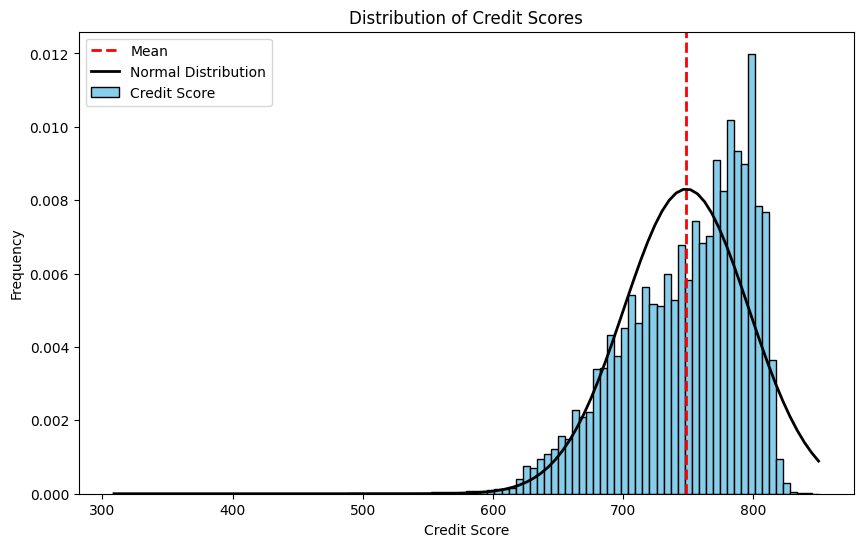

In [13]:
# plot the credit score
plt.figure(figsize=(10, 6))
df['CREDIT SCORE'] = df['CREDIT SCORE'].astype(int)
plt.hist(df['CREDIT SCORE'], bins=100, color='skyblue', edgecolor='black', density=True)  # 'density=True' for normalization
plt.axvline(df['CREDIT SCORE'].mean(), color='red', linestyle='dashed', linewidth=2)

# Adding a normal distribution curve
x = np.linspace(df['CREDIT SCORE'].min(), df['CREDIT SCORE'].max(), 100)
p = norm.pdf(x, df['CREDIT SCORE'].mean(), df['CREDIT SCORE'].std())
plt.plot(x, p, 'k', linewidth=2)

# Legend and labels
plt.legend(['Mean', 'Normal Distribution', 'Credit Score'])

plt.title('Distribution of Credit Scores')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')

plt.show()

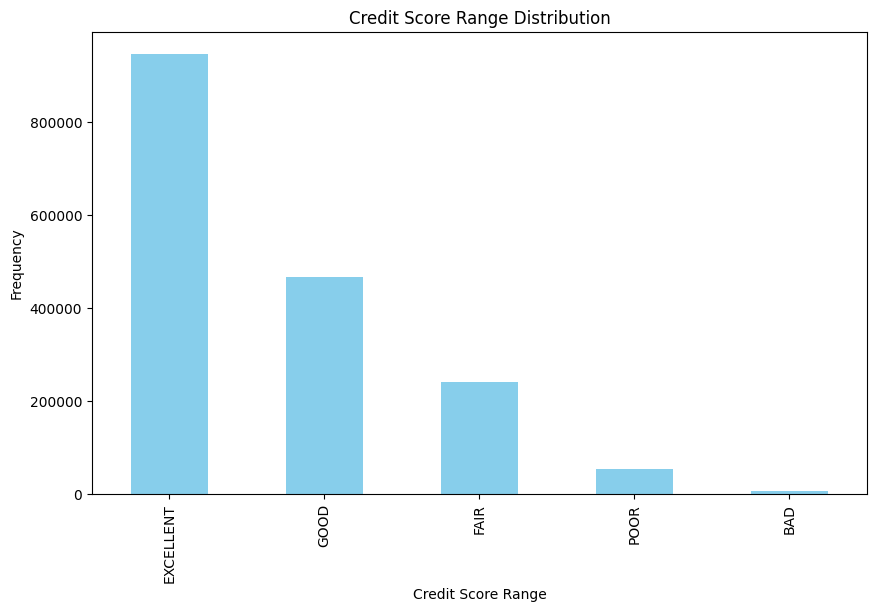

In [14]:
plt.figure(figsize=(10, 6))
df['CREDIT SCORE RANGE'].value_counts().plot(kind='bar', title='Credit Score Range Distribution', color='skyblue')
plt.xlabel('Credit Score Range')
plt.ylabel('Frequency')
plt.show()

In [15]:
# add columns credit score range to numerical value for the model
# example: EXCELLENT: 5 GOOD: 4 FAIR: 3 POOR: 2 BAD: 1
score_mapping = {'EXCELLENT': 5, 'GOOD': 4, 'FAIR': 3, 'POOR': 2, 'BAD': 1}
df['CREDIT SCORE RANGE NUM'] = df['CREDIT SCORE RANGE'].map(score_mapping)
df = df[['FIRST PAYMENT DATE', 'ESTIMATE BANK CLOSE DATE', 'CREDIT SCORE', 'CREDIT SCORE RANGE', 'CREDIT SCORE RANGE NUM', 
         'ORIGINAL LOAN AMOUNT', 'Home Value Index (ZHVI)', 'AMORTIZATION TYPE', 'PROPERTY TYPE']]
df.head()


,FIRST PAYMENT DATE,ESTIMATE BANK CLOSE DATE,CREDIT SCORE,CREDIT SCORE RANGE,CREDIT SCORE RANGE NUM,ORIGINAL LOAN AMOUNT,Home Value Index (ZHVI),AMORTIZATION TYPE,PROPERTY TYPE
0,2013-03,2013-02,714,GOOD,4,58000,138882.132777,FRM,SF
1,2008-04,2008-03,668,FAIR,3,46000,216843.365145,FRM,SF
2,2013-04,2013-03,765,EXCELLENT,5,42000,140557.261008,FRM,SF
3,2009-01,2008-12,747,GOOD,4,86000,180284.050463,FRM,PU
4,2010-06,2010-05,695,FAIR,3,58000,147697.394976,FRM,SF


In [28]:
df.sort_values(by='ESTIMATE BANK CLOSE DATE')

,ESTIMATE BANK CLOSE DATE,CREDIT SCORE,CREDIT SCORE RANGE,CREDIT SCORE RANGE NUM,ORIGINAL LOAN AMOUNT,Home Value Index (ZHVI),AMORTIZATION TYPE,PROPERTY TYPE,FL_30-89 days,FL_90+ days,Total Delinquency Rate,LTV RATIO
4923,2008-01,703,GOOD,4,120000,224286.406274,FRM,SF,4.4,2.5,6.9,0.535030
4886,2008-01,586,BAD,1,109000,224286.406274,FRM,SF,4.4,2.5,6.9,0.485986
4885,2008-01,658,FAIR,3,95000,224286.406274,FRM,SF,4.4,2.5,6.9,0.423566
4884,2008-01,627,POOR,2,110000,224286.406274,FRM,SF,4.4,2.5,6.9,0.490444
4882,2008-01,612,POOR,2,109000,224286.406274,FRM,SF,4.4,2.5,6.9,0.485986
...,...,...,...,...,...,...,...,...,...,...,...,...
1712797,2023-11,655,FAIR,3,125000,393478.895770,FRM,CO,1.4,0.6,2.0,0.317679
1711661,2023-11,766,EXCELLENT,5,170000,393478.895770,FRM,PU,1.4,0.6,2.0,0.432044
1694476,2023-12,746,GOOD,4,373000,394310.144353,FRM,PU,1.7,0.7,2.4,0.945956
1631539,2023-12,795,EXCELLENT,5,205000,394310.144353,FRM,SF,1.7,0.7,2.4,0.519895


In [16]:
temp = df['ESTIMATE BANK CLOSE DATE'].apply(lambda x: x.to_timestamp() if isinstance(x, pd.Period) else pd.to_datetime(x))
df.head()

,FIRST PAYMENT DATE,ESTIMATE BANK CLOSE DATE,CREDIT SCORE,CREDIT SCORE RANGE,CREDIT SCORE RANGE NUM,ORIGINAL LOAN AMOUNT,Home Value Index (ZHVI),AMORTIZATION TYPE,PROPERTY TYPE
0,2013-03,2013-02,714,GOOD,4,58000,138882.132777,FRM,SF
1,2008-04,2008-03,668,FAIR,3,46000,216843.365145,FRM,SF
2,2013-04,2013-03,765,EXCELLENT,5,42000,140557.261008,FRM,SF
3,2009-01,2008-12,747,GOOD,4,86000,180284.050463,FRM,PU
4,2010-06,2010-05,695,FAIR,3,58000,147697.394976,FRM,SF


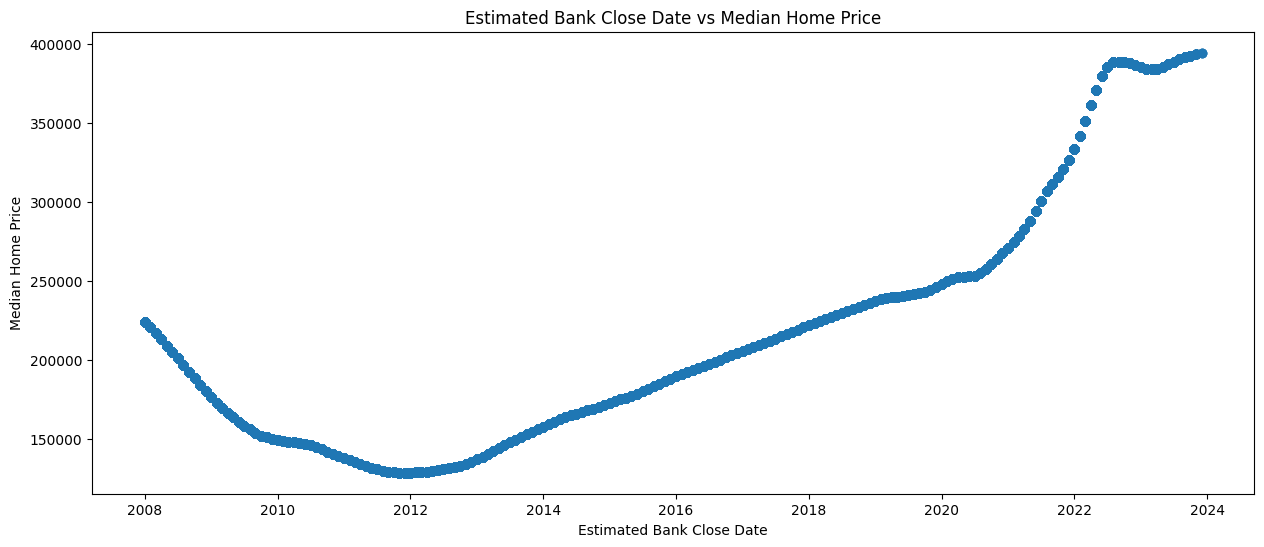

In [17]:
# plot estimated bank close date vs median home price
plt.figure(figsize=(15, 6))
plt.scatter(temp, df['Home Value Index (ZHVI)'])
plt.title('Estimated Bank Close Date vs Median Home Price')
plt.xlabel('Estimated Bank Close Date')
plt.ylabel('Median Home Price')
plt.show()


In [18]:
# add delinquency rate data
delinquency = pd.read_csv('data\deliquency_data.csv')

# select the data from 2008 to 2023 for the model
delinquency = delinquency[(delinquency['Date'] >= '2008-01') & (delinquency['Date'] <= '2023-12')]
delinquency['Date'] = pd.to_datetime(delinquency['Date']).dt.to_period('M')
delinquency.head()


,Date,FL_30-89 days,FL_90+ days,National_30-89 days
96,2008-01,4.4,2.5,1.393851
97,2008-02,4.0,2.6,NaN
98,2008-03,4.1,2.7,NaN
99,2008-04,4.0,2.8,1.386189
100,2008-05,4.2,2.9,NaN


In [19]:
# drop National_30-89 days and add 'Total Delinquency Rate' column to the dataframe 
delinquency = delinquency.drop(columns=['National_30-89 days'])
delinquency['Total Delinquency Rate'] = delinquency['FL_30-89 days'] + delinquency['FL_90+ days']
delinquency.head()

,Date,FL_30-89 days,FL_90+ days,Total Delinquency Rate
96,2008-01,4.4,2.5,6.9
97,2008-02,4.0,2.6,6.6
98,2008-03,4.1,2.7,6.8
99,2008-04,4.0,2.8,6.8
100,2008-05,4.2,2.9,7.1


In [20]:
# merge the delinquency data with the main dataframe
df = pd.merge(df, delinquency, left_on='ESTIMATE BANK CLOSE DATE', right_on='Date', how='inner')
df = df.drop(columns='Date')
df.head()

,FIRST PAYMENT DATE,ESTIMATE BANK CLOSE DATE,CREDIT SCORE,CREDIT SCORE RANGE,CREDIT SCORE RANGE NUM,ORIGINAL LOAN AMOUNT,Home Value Index (ZHVI),AMORTIZATION TYPE,PROPERTY TYPE,FL_30-89 days,FL_90+ days,Total Delinquency Rate
0,2013-03,2013-02,714,GOOD,4,58000,138882.132777,FRM,SF,3.2,6.9,10.1
1,2008-04,2008-03,668,FAIR,3,46000,216843.365145,FRM,SF,4.1,2.7,6.8
2,2013-04,2013-03,765,EXCELLENT,5,42000,140557.261008,FRM,SF,3.1,6.7,9.8
3,2009-01,2008-12,747,GOOD,4,86000,180284.050463,FRM,PU,5.5,5.0,10.5
4,2010-06,2010-05,695,FAIR,3,58000,147697.394976,FRM,SF,3.8,8.4,12.2


In [21]:
# drop the FIRST PAYMENT DATE column
df = df.drop(columns='FIRST PAYMENT DATE')

# Add LVT ratio column to the dataframe
df['LTV RATIO'] = df['ORIGINAL LOAN AMOUNT'] / df['Home Value Index (ZHVI)']

df.head()

,ESTIMATE BANK CLOSE DATE,CREDIT SCORE,CREDIT SCORE RANGE,CREDIT SCORE RANGE NUM,ORIGINAL LOAN AMOUNT,Home Value Index (ZHVI),AMORTIZATION TYPE,PROPERTY TYPE,FL_30-89 days,FL_90+ days,Total Delinquency Rate,LTV RATIO
0,2013-02,714,GOOD,4,58000,138882.132777,FRM,SF,3.2,6.9,10.1,0.417620
1,2008-03,668,FAIR,3,46000,216843.365145,FRM,SF,4.1,2.7,6.8,0.212135
2,2013-03,765,EXCELLENT,5,42000,140557.261008,FRM,SF,3.1,6.7,9.8,0.298811
3,2008-12,747,GOOD,4,86000,180284.050463,FRM,PU,5.5,5.0,10.5,0.477025
4,2010-05,695,FAIR,3,58000,147697.394976,FRM,SF,3.8,8.4,12.2,0.392695


In [22]:
# make a correlation matrix (CREDIT SCORE	CREDIT SCORE RANGE	CREDIT SCORE RANGE NUM	ORIGINAL LOAN AMOUNT	Median Home Price (NSA)	CPI-Adjusted Price)
corr = df[['CREDIT SCORE', 'CREDIT SCORE RANGE NUM', 'ORIGINAL LOAN AMOUNT', 'LTV RATIO', 'Home Value Index (ZHVI)', 'FL_30-89 days', 'FL_90+ days', 'Total Delinquency Rate']].corr()
display(corr)

,CREDIT SCORE,CREDIT SCORE RANGE NUM,ORIGINAL LOAN AMOUNT,LTV RATIO,Home Value Index (ZHVI),FL_30-89 days,FL_90+ days,Total Delinquency Rate
CREDIT SCORE,1.000000,0.937371,0.035236,0.045874,-0.027843,0.008054,0.048424,0.037443
CREDIT SCORE RANGE NUM,0.937371,1.000000,0.056522,0.060850,-0.016313,-0.000703,0.036189,0.025872
ORIGINAL LOAN AMOUNT,0.035236,0.056522,1.000000,0.746245,0.369896,-0.300277,-0.289677,-0.303173
LTV RATIO,0.045874,0.060850,0.746245,1.000000,-0.261413,0.204311,0.265835,0.255841
Home Value Index (ZHVI),-0.027843,-0.016313,0.369896,-0.261413,1.000000,-0.763070,-0.798750,-0.815576
FL_30-89 days,0.008054,-0.000703,-0.300277,0.204311,-0.763070,1.000000,0.842308,0.921398
FL_90+ days,0.048424,0.036189,-0.289677,0.265835,-0.798750,0.842308,1.000000,0.985566
Total Delinquency Rate,0.037443,0.025872,-0.303173,0.255841,-0.815576,0.921398,0.985566,1.000000


<Axes: >

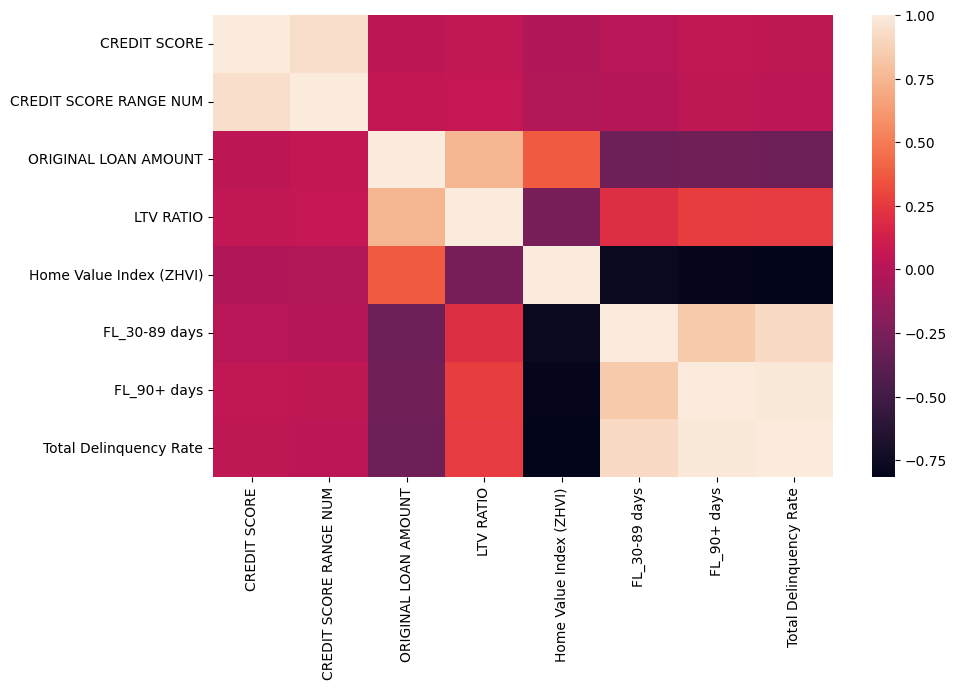

In [23]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr)

In [24]:
# summary statistics
summary = df[['CREDIT SCORE', 'CREDIT SCORE RANGE NUM', 'ORIGINAL LOAN AMOUNT', 'LTV RATIO', 'Home Value Index (ZHVI)', 'FL_30-89 days', 'FL_90+ days', 'Total Delinquency Rate']].describe()
summary

,CREDIT SCORE,ORIGINAL LOAN AMOUNT,LTV RATIO,Home Value Index (ZHVI),FL_30-89 days,FL_90+ days,Total Delinquency Rate
count,1.716321e+06,1.716321e+06,1.716321e+06,1.716321e+06,1.716321e+06,1.716321e+06,1.716321e+06
mean,7.484772e+02,2.264245e+05,1.005605e+00,2.354286e+05,2.016212e+00,2.655712e+00,4.671923e+00
std,4.803819e+01,1.174436e+05,5.208528e-01,7.582171e+04,1.195701e+00,2.744800e+00,3.806898e+00
min,3.090000e+02,6.000000e+03,2.869727e-02,1.288214e+05,6.000000e-01,5.000000e-01,1.200000e+00
25%,7.150000e+02,1.370000e+05,6.226801e-01,1.691065e+05,9.000000e-01,6.000000e-01,1.500000e+00
50%,7.580000e+02,2.040000e+05,8.989817e-01,2.312262e+05,1.900000e+00,1.200000e+00,3.100000e+00
75%,7.880000e+02,2.970000e+05,1.285435e+00,2.828662e+05,2.800000e+00,4.000000e+00,7.100000e+00
max,8.500000e+02,1.135000e+06,6.213056e+00,3.943101e+05,5.500000e+00,8.900000e+00,1.330000e+01


In [25]:
from sklearn.cluster import KMeans

# scale the data
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[['CREDIT SCORE', 'CREDIT SCORE RANGE NUM', 'ORIGINAL LOAN AMOUNT', 'LTV RATIO', 'Home Value Index (ZHVI)', 'FL_30-89 days', 'FL_90+ days', 'Total Delinquency Rate']] = scaler.fit_transform(df[['CREDIT SCORE', 'CREDIT SCORE RANGE NUM', 'ORIGINAL LOAN AMOUNT', 'LTV RATIO', 'Home Value Index (ZHVI)', 'FL_30-89 days', 'FL_90+ days', 'Total Delinquency Rate']])

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=0)
df_scaled['CREDIT SCORE CLUSTER'] = kmeans.fit_predict(df_scaled[['CREDIT SCORE']])

display(df_scaled.head())


,ESTIMATE BANK CLOSE DATE,CREDIT SCORE,CREDIT SCORE RANGE,CREDIT SCORE RANGE NUM,ORIGINAL LOAN AMOUNT,Home Value Index (ZHVI),AMORTIZATION TYPE,PROPERTY TYPE,FL_30-89 days,FL_90+ days,Total Delinquency Rate,LTV RATIO,CREDIT SCORE CLUSTER
0,2013-02,0.748614,GOOD,0.75,0.046058,0.037895,FRM,SF,0.530612,0.761905,0.735537,0.062888,3
1,2008-03,0.663586,FAIR,0.50,0.035430,0.331547,FRM,SF,0.714286,0.261905,0.462810,0.029662,1
2,2013-03,0.842884,EXCELLENT,1.00,0.031887,0.044205,FRM,SF,0.510204,0.738095,0.710744,0.043677,4
3,2008-12,0.809612,GOOD,0.75,0.070859,0.193841,FRM,PU,1.000000,0.535714,0.768595,0.072494,0
4,2010-05,0.713494,FAIR,0.50,0.046058,0.071099,FRM,SF,0.653061,0.940476,0.909091,0.058858,3


In [26]:
len(df_scaled)

1716321

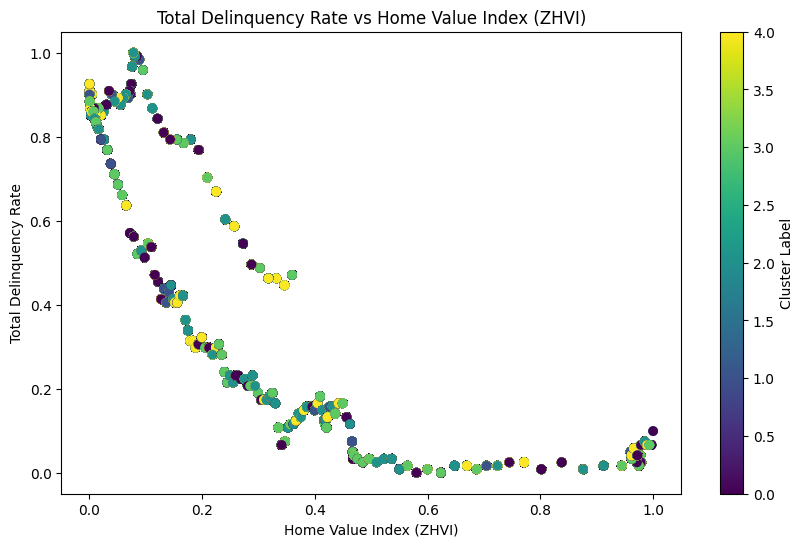

In [191]:
# plot the scaled data Y (Total Delinquency Rate) vs X (CREDIT SCORE) with clusters
plt.figure(figsize=(10, 6))
# plt.scatter(df_scaled['CREDIT SCORE'], df_scaled['Total Delinquency Rate'], c=df_scaled['CREDIT SCORE CLUSTER'], cmap='viridis')
plt.scatter(df_scaled['Home Value Index (ZHVI)'], df_scaled['Total Delinquency Rate'], c=df_scaled['CREDIT SCORE CLUSTER'])

plt.title('Total Delinquency Rate vs Home Value Index (ZHVI)')
plt.xlabel('Home Value Index (ZHVI)')
plt.ylabel('Total Delinquency Rate')
plt.colorbar(label='Cluster Label')
plt.show()


In [192]:
# R squared value for the model
from sklearn.linear_model import LinearRegression

# Linear Regression
X = df_scaled[['CREDIT SCORE CLUSTER', 'ORIGINAL LOAN AMOUNT', 'LTV RATIO', 'Home Value Index (ZHVI)']]
y = df_scaled['Total Delinquency Rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

In [193]:
# print model summary
print(f'R squared value: {r2}')
print(f'Mean Squared Error: {mse}')

R squared value: 0.6830430121456044
Mean Squared Error: 0.03130966294081511


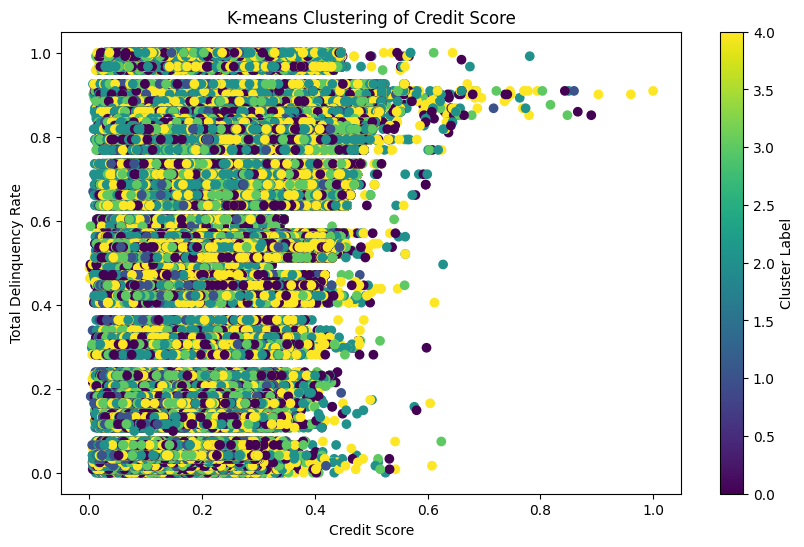

In [194]:
# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(df_scaled['LTV RATIO'], df_scaled['Total Delinquency Rate'], c=df_scaled['CREDIT SCORE CLUSTER'], cmap='viridis')
plt.xlabel('Credit Score')
plt.ylabel('Total Delinquency Rate')
plt.title('K-means Clustering of Credit Score')
plt.colorbar(label='Cluster Label')
plt.show()

In [150]:
X = df[['LTV RATIO', 'CREDIT SCORE']]
y = df['Total Delinquency Rate']

In [196]:
df_scaled['Home Value Index (ZHVI)^2'] = df_scaled['Home Value Index (ZHVI)'] ** 2
df_scaled['Home Value Index (ZHVI)^3'] = df_scaled['Home Value Index (ZHVI)'] ** 3


In [197]:
# to csv file
df_scaled.to_csv('data\FL_scale_cleaned.csv', index=False)

In [198]:
# get excellent credit score data
df_scale_excellent = df_scaled[(df_scaled['CREDIT SCORE RANGE'] == 'EXCELLENT')]
df_scale_excellent.head()

,ESTIMATE BANK CLOSE DATE,CREDIT SCORE,CREDIT SCORE RANGE,CREDIT SCORE RANGE NUM,ORIGINAL LOAN AMOUNT,Home Value Index (ZHVI),AMORTIZATION TYPE,PROPERTY TYPE,FL_30-89 days,FL_90+ days,Total Delinquency Rate,LTV RATIO,CREDIT SCORE CLUSTER,Home Value Index (ZHVI)^2,Home Value Index (ZHVI)^3
2,2013-03,0.842884,EXCELLENT,1.0,0.031887,0.044205,FRM,SF,0.510204,0.738095,0.710744,0.043677,4,0.001954,0.000086
5,2008-12,0.848429,EXCELLENT,1.0,0.081488,0.193841,FRM,SF,1.000000,0.535714,0.768595,0.083257,4,0.037574,0.007283
6,2009-11,0.824399,EXCELLENT,1.0,0.092117,0.083958,FRM,PU,0.816327,0.964286,0.991736,0.113066,4,0.007049,0.000592
8,2009-03,0.902033,EXCELLENT,1.0,0.131975,0.155048,FRM,CO,0.857143,0.654762,0.793388,0.142804,2,0.024040,0.003727
11,2008-05,0.898336,EXCELLENT,1.0,0.100089,0.302302,FRM,PU,0.734694,0.285714,0.487603,0.087392,2,0.091386,0.027626


C:\Users\xiaming\AppData\Local\Temp\ipykernel_26816\545792399.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


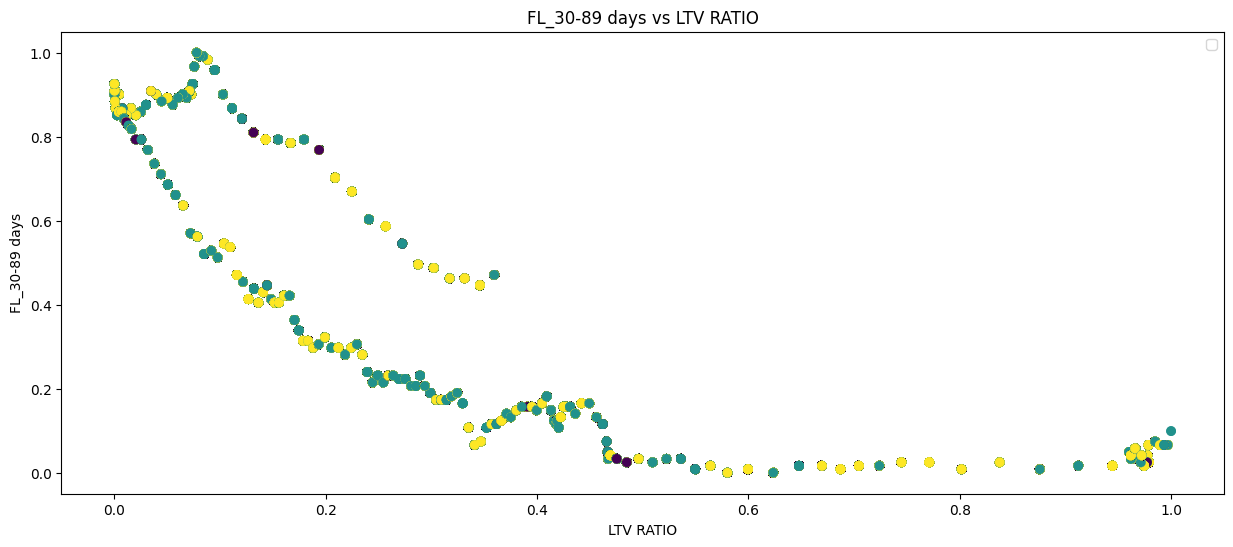

In [199]:
# plot the scaled data Y (Total Delinquency Rate) vs X (CREDIT SCORE) with clusters
plt.figure(figsize=(15, 6))
# plt.scatter(df_scaled['CREDIT SCORE'], df_scaled['Total Delinquency Rate'], c=df_scaled['CREDIT SCORE CLUSTER'], cmap='viridis')
plt.scatter(df_scale_excellent['Home Value Index (ZHVI)'], df_scale_excellent['Total Delinquency Rate'], c=df_scale_excellent['CREDIT SCORE CLUSTER'])
plt.title('FL_30-89 days vs LTV RATIO')
plt.xlabel('LTV RATIO')
plt.ylabel('FL_30-89 days')
plt.legend()
plt.show()

In [206]:
X_scale = df_scale_excellent[['Home Value Index (ZHVI)', 'Home Value Index (ZHVI)^2', 'Home Value Index (ZHVI)^3']]
y_scale = df_scale_excellent['Total Delinquency Rate']

In [205]:
X_scale = sm.add_constant(X_scale)
model_S = sm.OLS(y_scale, X_scale).fit()

print(model_S.summary())

                              OLS Regression Results                              
Dep. Variable:     Total Delinquency Rate   R-squared:                       0.900
Model:                                OLS   Adj. R-squared:                  0.900
Method:                     Least Squares   F-statistic:                 4.257e+06
Date:                    Sun, 27 Oct 2024   Prob (F-statistic):               0.00
Time:                            16:54:53   Log-Likelihood:             8.0168e+05
No. Observations:                  947548   AIC:                        -1.603e+06
Df Residuals:                      947545   BIC:                        -1.603e+06
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [201]:
# import statsmodels.api as sm

# X = sm.add_constant(X)
# model_S = sm.OLS(y, X).fit()

# print(model_S.summary())

In [ ]:
# Random Forest Regressor
X = df[['CREDIT SCORE', 'CREDIT SCORE RANGE NUM', 'ORIGINAL LOAN AMOUNT', 'LTV RATIO', 'CPI-Adjusted Price']]
y = df['Total Delinquency Rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(oob_score=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# print model summary
print(f'R squared value: {r2}')
print(f'Mean Squared Error: {mse}')
print(f'Out-of-Bag Score: {model.oob_score_}')

R squared value: 1.0
Mean Squared Error: 1.6943787822817036e-28
Out-of-Bag Score: 0.9999999992299446


In [ ]:
# plot the tree model
# plt.figure(figsize=(20, 10))
# plot_tree(model.estimators_[0], feature_names=X.columns, filled=True)
# plt.show()

In [ ]:
# Gradient Boosting Regressor
X = df[['CREDIT SCORE', 'CREDIT SCORE RANGE NUM', 'ORIGINAL LOAN AMOUNT', 'Random Forest Regressor', 'CPI-Adjusted Price']]
y = df['Total Delinquency Rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# print model summary
print(f'R squared value: {r2}')
print(f'Mean Squared Error: {mse}')

R squared value: 0.9984834601371554
Mean Squared Error: 0.02193323199745301


In [200]:

# df.to_csv('data/FL_cleaned.csv', index=False)